In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

import matplotlib.pylab as plt
import numpy as np

In [2]:
train_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)

In [3]:
batch_size = 64

train_loader = DataLoader(train_data, batch_size=batch_size)

test_loader = DataLoader(test_data, batch_size=batch_size)

In [4]:
train_data[102]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.5922, 0.5882, 0.5647, 0.5412, 0.4667, 0.6078,
           0.5647, 0.6078, 0.3882, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0196, 1.0000, 0.9922, 0.9961, 1.0000, 0.9922, 0.9961,
           0.9725, 0.9373, 0.9333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.2980, 1.0000, 0.8824, 0.9137, 0.9137, 0.8745, 0.8706,
           0.8902, 0.8118, 0.9098, 0.1098, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.3725, 1.0000, 0.8510, 0.9333, 0.9373, 0.8824, 0.9059,
           0.9294, 0.8157, 0.9216, 0.2706, 

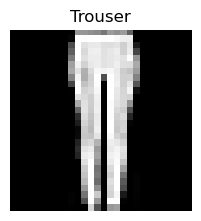

In [5]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8,8))
cols, rows = 3, 3

img, label = train_data[102]
figure.add_subplot(rows, cols, 1)
plt.title(labels_map[label])
plt.axis('off')
plt.imshow(img.squeeze(), cmap='gray')
plt.show()

In [6]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [7]:
for X, y in test_loader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [8]:
device = 'cuda'

class NNet(nn.Module):
    def __init__(self):
        super(NNet, self).__init__()
        
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(512, 10),
        )
    
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NNet().to(device)
print(model)

NNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): ReLU()
    (5): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [9]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [10]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [11]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [12]:
epochs = 6
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    test(test_loader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.289787  [   64/60000]
loss: 2.292773  [ 6464/60000]
loss: 2.273393  [12864/60000]
loss: 2.271569  [19264/60000]
loss: 2.250118  [25664/60000]
loss: 2.222028  [32064/60000]
loss: 2.227247  [38464/60000]
loss: 2.187756  [44864/60000]
loss: 2.202537  [51264/60000]
loss: 2.157217  [57664/60000]


KeyboardInterrupt: 

In [13]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [14]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [ ]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[114]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

In [ ]:
pred[0].size()

In [ ]:
pred[0].argmax(0)

In [ ]:
pred[0]

In [ ]:
data = [[1, 2],[3, 4]]
x_data = torch.tensor(data)

x_ones = torch.ones_like(x_data) # retains the properties of x_data
print(f"Ones Tensor: \n {x_ones} \n")

x_rand = torch.rand_like(x_data, dtype=torch.float) # overrides the datatype of x_data
print(f"Random Tensor: \n {x_rand} \n")

In [ ]:
shape = (2,2,3)
rand_tensor = torch.rand(shape)
ones_tensor = torch.ones(shape)
zeros_tensor = torch.zeros(shape)

print(f"Random Tensor: \n {rand_tensor} \n")
print(f"Ones Tensor: \n {ones_tensor} \n")
print(f"Zeros Tensor: \n {zeros_tensor}")

In [ ]:
print(rand_tensor[0], '\n',rand_tensor[1])

In [ ]:
print(rand_tensor[0][0], '\n',rand_tensor[1][0])

In [ ]:
tensor = torch.rand(3,4)

print(f"Shape of tensor: {tensor.shape}")
print(f"Datatype of tensor: {tensor.dtype}")
print(f"Device tensor is stored on: {tensor.device}")

In [ ]:
t1 = torch.cat([tensor, tensor, tensor], dim=1)
print(t1)

In [ ]:
agg = tensor.sum()
print(agg)

In [15]:
ds = datasets.FashionMNIST(
    root='./data',
    train = True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))
)

In [16]:
dl = DataLoader(ds, batch_size=64, shuffle=True)

In [17]:
y = torch.zeros(10, dtype=torch.float)
print(y)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [18]:
x = torch.ones(3,5)
y = torch.zeros(3)
print('x and y: ', x, y)
w = torch.randn((5, 3))
print('weight ', w)
b = torch.randn(3)
print('bias ', b)
z = torch.matmul(x,w)
print('mul ', z)

x and y:  tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]]) tensor([0., 0., 0.])
weight  tensor([[-0.4686, -0.0343,  1.4174],
        [ 0.1815,  0.6865, -1.5731],
        [-0.7827, -1.2000, -0.8378],
        [-0.5361,  0.2357,  1.3920],
        [ 1.3130,  0.7457,  0.1825]])
bias  tensor([ 1.8393, -0.5807,  0.4658])
mul  tensor([[-0.2930,  0.4337,  0.5812],
        [-0.2930,  0.4337,  0.5812],
        [-0.2930,  0.4337,  0.5812]])


In [22]:
### x.col = 3, x.row = 1
x = torch.tensor([1, 2, 3])
### y.col = 2; y.row = 3
tt = [[1, 2], [5, 6], [8,9]]
y = torch.tensor(tt)

### x = [1, 2, 3]
### y = [1, 2]
###     [5, 6]
###     [8, 9]
### matmul = col x row (col.size == row.size)
print(torch.matmul(x, y))

tensor([35, 41])
